# Momento de Retroalimentación: Módulo 2 Implementación de un modelo de deep learning

## 0.Introducción

El objetivo de este notebook es implementar un modelo de deep learning no denso para poder resolver un problema de clasificación. En este caso haremos que nuestro modelo aprenda a diferenciar entre imágenes de perritos y gatitos. Finalmente haremos una breve conclusión y se agregará una sección que permita cargar una imagen para probar el modelo entrenado.

## 1.Instalar dependencias

In [129]:
!pip install tensorflow opencv-python matplotlib

In [130]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, BinaryAccuracy


## 2.Preprocesamiento de los datos

Seleccionamos nuestro directorio con imágenes y los formatos permitidos

In [131]:
image_directory = 'images'
image_extensions = ['jpeg', 'jpg', 'bmp', 'png']

Veamos cuántas imágenes hay actualmente en nuestros directorios

In [132]:
# Mostramos el numero de imagenes de gatitos
print('KITTENS: ',len(os.listdir(os.path.join(image_directory, 'kittens'))))
# Mostramos el numero de imagenes de perritos
print('PUPPERS: ',len(os.listdir(os.path.join(image_directory, 'puppers'))))

KITTENS:  149
PUPPERS:  158


Ahora eliminaremos las imágenes que no cumplan con los formatos definidos anteriormente y veamos cuántos ejemplos nos quedan de cada clase

In [133]:
for image_class in os.listdir(image_directory):
    for image in os.listdir(os.path.join(image_directory, image_class)):
        image_path = os.path.join(image_directory, image_class, image)
        try:
            # Checa que podamos cargar la imágen en opencv
            img = cv2.imread(image_path)
            # Checa que nuestra imagen tenga las extension permitida
            img_ext = imghdr.what(image_path)
            if img_ext not in image_extensions:
                os.remove(image_path)
        except Exception as e:
            os.remove(image_path)



In [134]:
# Mostramos el numero de imagenes de gatitos
print('KITTENS: ',len(os.listdir(os.path.join(image_directory, 'kittens'))))
# Mostramos el numero de imagenes de perritos
print('PUPPERS: ',len(os.listdir(os.path.join(image_directory, 'puppers'))))

KITTENS:  149
PUPPERS:  158


Guardaremos nuestras imágenes en una variable y keras nos confirmará la cantidad de imágenes y clases guardadas

In [135]:
images = tf.keras.utils.image_dataset_from_directory('images')

Found 307 files belonging to 2 classes.


Inicializaremos nuestro iterador de imágenes y mostraremos el primer batch para confirmar que las imágenes están bien antes de comenzar el entrenamiento

In [136]:
image_iterator = images.as_numpy_iterator()
batch = image_iterator.next()

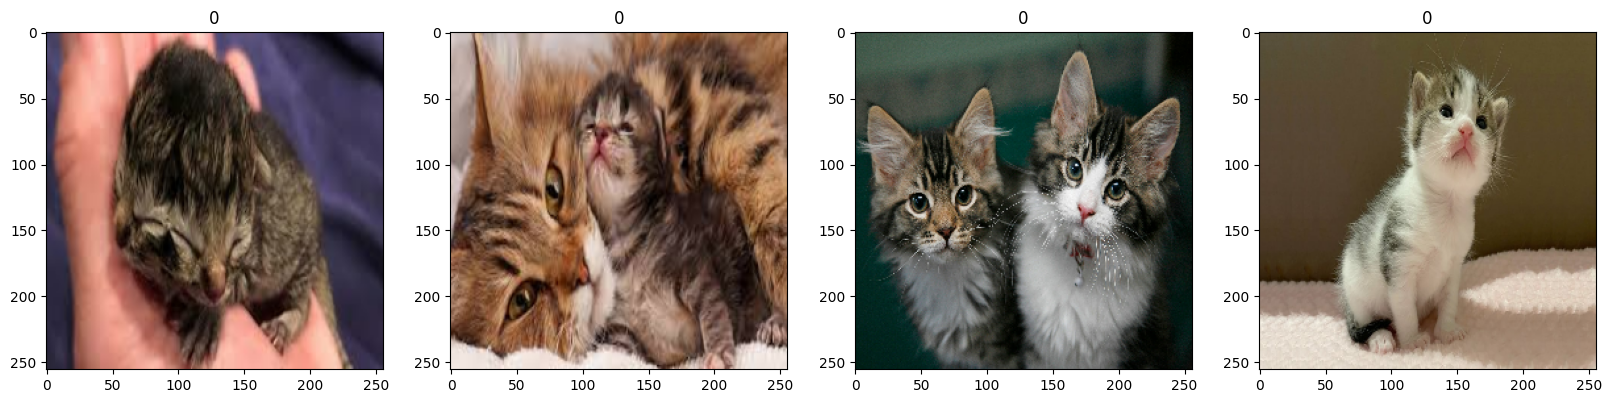

In [137]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Ahora normalizaremos las imágenes de valores de las imágenes de 0-255 a 0-1 para que el entranamiento sea más rápido

In [138]:
# Vamos a cambiar la representación de los valores numéricos de las imagenes de (0 - 255) a (0 - 1)
images = images.map(lambda x, y: (x/255, y))

Para evitar que nuestro modelo haga overfitting, dividiremos nuestros datos en train, test y validation. Imprimiremos cuantos batches hay en cada uno

In [139]:
train_set = int(len(images)*.7)
validation_set = int(len(images)*.2)
test_set = int(len(images)*.1)
print(f'Train: {train_set}')
print(f'Test: {test_set}')
print(f'Validation: {validation_set}')

Train: 7
Test: 1
Validation: 2


Ahora guardaremos las imagenes necesarias para el entrenamiento y armaremos los sets

In [140]:
# set de entrenamiento
train_data = images.take(train_set)
# set de validacion
validation_data = images.skip(train_set).take(validation_set)
# set de prueba
test_data = images.skip(train_set + validation_set).take(test_set)

## 3.Construcción del modelo

A continuación construiremos el modelo. Como la actividad lo requiere, se usará un modelo secuencial y no uno denso. Nuestro modelo contará con tres capas de convolución, cada una con el doble de neuronas de la anterior y finalmente una capa de flatten para poder agregar dos capas densas al final para poder clasificar nuestras imágenes en clases. 

In [141]:
model = Sequential()

model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [142]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

Este es un resumen de nuestro modelo:

In [143]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 64)      

Para guardar la información de nuestro modelo, asignaremos un directorio

In [144]:
log_directory = 'logs'

In [145]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_directory)

Ahora entrenaremos nuestro modelo

In [146]:
hist = model.fit(train_data, epochs = 20, validation_data = validation_data, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 11s 1s/step - loss: 1.2732 - accuracy: 0.5357 - val_loss: 0.8206 - val_accuracy: 0.4844
Epoch 2/20
7/7 [==============================] - 8s 1s/step - loss: 0.6954 - accuracy: 0.5357 - val_loss: 0.6867 - val_accuracy: 0.5000
Epoch 3/20
7/7 [==============================] - 8s 1s/step - loss: 0.6988 - accuracy: 0.5491 - val_loss: 0.6603 - val_accuracy: 0.6094
Epoch 4/20
7/7 [==============================] - 9s 1s/step - loss: 0.6797 - accuracy: 0.5536 - val_loss: 0.6781 - val_accuracy: 0.6875
Epoch 5/20
7/7 [==============================] - 8s 1s/step - loss: 0.6527 - accuracy: 0.6071 - val_loss: 0.7129 - val_accuracy: 0.4688
Epoch 6/20
7/7 [==============================] - 9s 1s/step - loss: 0.6298 - accuracy: 0.6250 - val_loss: 0.5898 - val_accuracy: 0.6562
Epoch 7/20
7/7 [==============================] - 8s 1s/step - loss: 0.6167 - accuracy: 0.6562 - val_loss: 0.5385 - val_accuracy: 0.7969
Epoch 8/20
7/7 [========================

## 4.Evaluando el desempeño del modelo

Ahora graficaremos nuestros datos de pérdida en comparación con las épocas transcurridas y luego nuestros datos de precisión con las épocas transcurridas

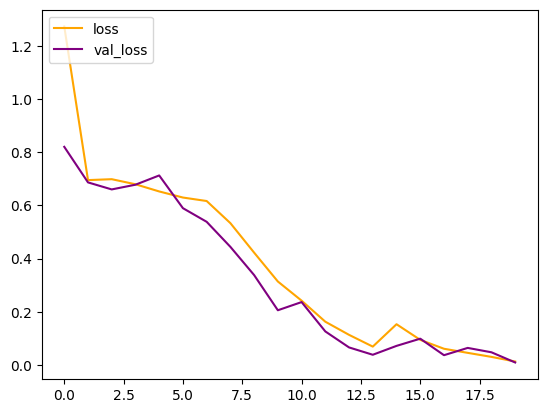

In [147]:
figure = plt.figure()
plt.plot(hist.history['loss'], color='orange', label='loss')
plt.plot(hist.history['val_loss'], color='purple', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

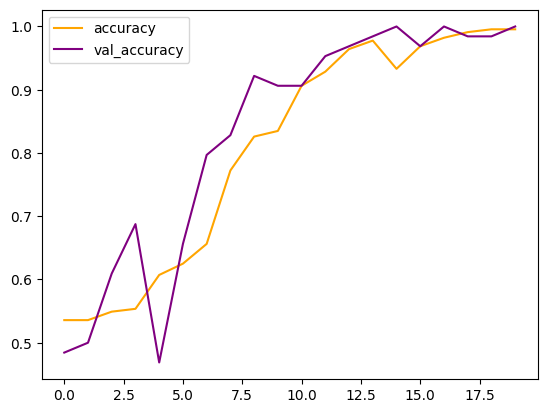

In [148]:
figure = plt.figure()
plt.plot(hist.history['accuracy'], color='orange', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='purple', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

Podemos observar que en ambas gráficas, nuestro modelo no se separa mucho de nuestros datos de validación, por lo que podemos afirmar que no se está haciendo overfitting. Además, con el paso de las épocas de entrenamiento, nuestra pérdida se reduce y nuestra precisión aumenta, así que podemos concluir que nuestro modelo está aprendiendo eficientemente.

Finalmente evaluaremos nuestro modelo con el set de test, ya que estos datos nunca han sido vistos por el modelo y nos dará una mejor idea de la precisión que tiene nuestro modelo en realidad. Haremos uso de las funciones precission y accuracy para poder visualizar su desempeño de manera numérica.

In [150]:
precision = Precision()

accuracy = BinaryAccuracy()

In [152]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 277ms/step


In [154]:
print(f'Precision: {precision.result().numpy()}\n Accuracy: {accuracy.result().numpy()}')

Precision: 1.0
 Accuracy: 1.0


## 5.Conclusión

Esta implementación es buena para resolver diferentes problemas de clasificación de imágenes, ya que podemos hacer uso de herramientas como la extensión de google chrome "Download All Images" para recopilar muchas imágenes en poco tiempo porque dentro de nuestro preprocesamiento de datos ya limpiamos las imágenes que no cuentan con el formato correcto. Si bien el modelo ha entregado buenos resultados, este tiene podría tener algunos defectos al hacer varias pruebas, ya que el dataset con el que se entrenó no es muy grande. En caso de ser necesario mejorarlo, se podrían modificar algunos hiperparámetros como las neuronas usadas en cada capa, el número de épocas o el número de capas, pero como los resultados han sido satisfactorios, por el momento nos quedaremos con esta implementación inicial.

A continuación se puede cargar una imágen para probar rápidamente el modelo.

## 6.Carga una imagen aqui

Puedes agregar una imagen al directorio raiz y probar el modelo a continuación:

Nota: tienes que cambiar el nombre dentro de imread()

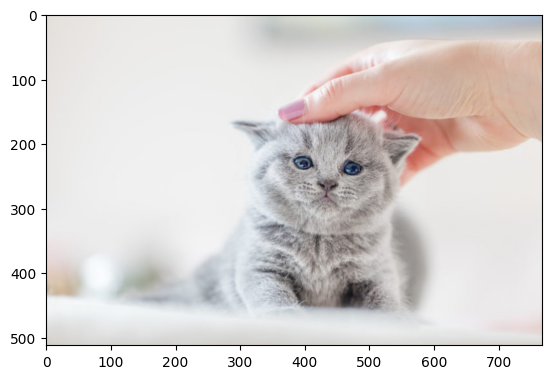

In [165]:

import cv2

img = cv2.imread('gatito.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

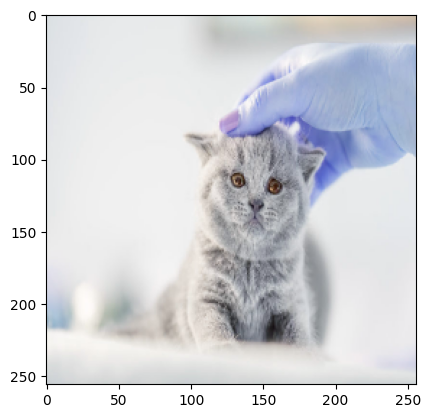

In [166]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [168]:
np.expand_dims(resize,0).shape

(1, 256, 256, 3)

In [169]:
yhat = model.predict(np.expand_dims(resize/255,0))
yhat

1/1 [==============================] - 0s 48ms/step


array([[0.9483541]], dtype=float32)

In [170]:
if yhat > 0.5:
    print(f'This is a kitten')
else:
    print(f'This is a pupper')

This is a kitten
